In [1]:
import os
import time
import shutil
import pathlib
import itertools
from PIL import Image

import cv2
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_style('darkgrid')
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, GlobalMaxPooling2D, Flatten, Dense, Activation, Dropout, BatchNormalization
from tensorflow.keras import regularizers

import warnings
warnings.filterwarnings("ignore")

print ('modules loaded')

modules loaded


In [2]:
data_path = "../data/raw/train"


print(os.path.exists(data_path))
print(os.listdir(data_path))

images = []
labels = []

for category_folder in os.listdir(data_path):
    category_path = os.path.join(data_path, category_folder)
    
    if not os.path.isdir(category_path):
        continue
    
    subitems = os.listdir(category_path)
    
    if any(os.path.isdir(os.path.join(category_path, item)) for item in subitems):
        for subfolder in subitems:
            subfolder_path = os.path.join(category_path, subfolder)
            
            if not os.path.isdir(subfolder_path):
                continue
            
            label_name = subfolder
            
            for image_filename in os.listdir(subfolder_path):
                if image_filename.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.tiff')):
                    image_path = os.path.join(subfolder_path, image_filename)
                    images.append(image_path)
                    labels.append(label_name)
    else:
        label_name = category_folder
        
        for image_filename in os.listdir(category_path):
            if image_filename.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.tiff')):
                image_path = os.path.join(category_path, image_filename)
                images.append(image_path)
                labels.append(label_name)

True
['ECG Images of Myocardial Infarction Patients (240x12=2880)', 'ECG Images of Patient that have abnormal heartbeat (233x12=2796)', 'ECG Images of Patient that have History of MI (172x12=2064)', 'Normal Person ECG Images (284x12=3408)']


In [3]:
data = pd.DataFrame({'image': images, 'label': labels})

print(f"Total images found: {len(data)}")
print("Label distribution:")
print(data['label'].value_counts())

Total images found: 3023
Label distribution:
label
ECG Images of Myocardial Infarction Patients (240x12=2880)          956
Normal Person ECG Images (284x12=3408)                              852
ECG Images of Patient that have abnormal heartbeat (233x12=2796)    699
ECG Images of Patient that have History of MI (172x12=2064)         516
Name: count, dtype: int64


In [4]:
strat = data['label']
train_df, dummy_df = train_test_split(data, train_size=0.80, shuffle=True, random_state=123, stratify=strat)

strat = dummy_df['label']
valid_df, test_df = train_test_split(dummy_df, train_size=0.5, shuffle=True, random_state=123, stratify=strat)

print(f"Training set: {len(train_df)} images")
print(f"Validation set: {len(valid_df)} images")
print(f"Test set: {len(test_df)} images")

Training set: 2418 images
Validation set: 302 images
Test set: 303 images


In [5]:
batch_size = 32
img_size = (100, 100)
channels = 3
img_shape = (img_size[0], img_size[1], channels)

tr_gen = ImageDataGenerator(rescale=1./255)  
ts_gen = ImageDataGenerator(rescale=1./255) 

train_gen = tr_gen.flow_from_dataframe(
    train_df, 
    x_col='image', 
    y_col='label', 
    target_size=img_size, 
    class_mode='categorical', 
    color_mode='rgb', 
    shuffle=True, 
    batch_size=batch_size
)

valid_gen = ts_gen.flow_from_dataframe(
    valid_df, 
    x_col='image', 
    y_col='label', 
    target_size=img_size, 
    class_mode='categorical', 
    color_mode='rgb', 
    shuffle=True, 
    batch_size=batch_size
)

test_gen = ts_gen.flow_from_dataframe(
    test_df, 
    x_col='image', 
    y_col='label', 
    target_size=img_size, 
    class_mode='categorical', 
    color_mode='rgb', 
    shuffle=False, 
    batch_size=batch_size
)

print("Class indices:", train_gen.class_indices)

Found 2418 validated image filenames belonging to 4 classes.
Found 302 validated image filenames belonging to 4 classes.
Found 303 validated image filenames belonging to 4 classes.
Class indices: {'ECG Images of Myocardial Infarction Patients (240x12=2880)': 0, 'ECG Images of Patient that have History of MI (172x12=2064)': 1, 'ECG Images of Patient that have abnormal heartbeat (233x12=2796)': 2, 'Normal Person ECG Images (284x12=3408)': 3}


In [6]:
class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        if logs is None:
            logs = {}
        accuracy = logs.get('accuracy')
        val_accuracy = logs.get('val_accuracy')
        
        if accuracy:
            print(f"Epoch {epoch + 1}: Training accuracy is {accuracy:.4f}")
        if val_accuracy:
            print(f"Epoch {epoch + 1}: Validation accuracy is {val_accuracy:.4f}")
        
        if (accuracy and accuracy > 0.99) or (val_accuracy and val_accuracy > 0.99):
            print("\nReached 99% accuracy in training or validation, so cancelling training!")

In [7]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, GlobalAveragePooling2D, Dense, Dropout, BatchNormalization 
from tensorflow.keras import regularizers

n_classes = 4
input_shape = (100, 100, 3)

model = Sequential()

model.add(Conv2D(16, (3,3), activation='relu', input_shape=input_shape, padding='same')) 
model.add(BatchNormalization())
model.add(MaxPooling2D(2)) 

model.add(Conv2D(32, (3,3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(2)) 
model.add(Dropout(0.25))


model.add(Conv2D(64, (3,3), activation='relu', padding='same')) 
model.add(BatchNormalization())
model.add(MaxPooling2D(2)) 
model.add(Dropout(0.25))

model.add(Conv2D(128, (3,3), activation='relu', padding='same')) 
model.add(BatchNormalization())
model.add(MaxPooling2D(2)) 
model.add(Dropout(0.25))


model.add(GlobalAveragePooling2D())

model.add(Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)))
model.add(Dense(64, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)))
model.add(Dense(32, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)))

model.add(Dense(n_classes, activation='softmax'))

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 100, 100, 16)        │             448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 100, 100, 16)        │              64 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 50, 50, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 50, 50, 32)          │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 50, 50, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 25, 25, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 25, 25, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 25, 25, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 25, 25, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 12, 12, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 12, 12, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 12, 12, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 12, 12, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 6, 6, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 6, 6, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 128)                 │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │          16,512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 32)                  │           2,0

 Total params: 125,380 (489.77 KB)

 Trainable params: 124,900 (487.89 KB)

 Non-trainable params: 480 (1.88 KB)

In [8]:
from tensorflow.keras.callbacks import ReduceLROnPlateau, LearningRateScheduler


def lr_scheduler(epoch, lr):
    new_lr = lr * tf.math.exp(-0.1)
    return float(new_lr.numpy())

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss', 
    factor=0.2, 
    patience=5, 
    min_lr=0.0001
)

callbacks = [
    myCallback(),
    LearningRateScheduler(lr_scheduler),
    reduce_lr
]

model.compile(optimizer=tf.keras.optimizers.Adamax(learning_rate=0.001), 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

history = model.fit(
    train_gen,
    epochs=15,
    batch_size=32,
    verbose=2,
    validation_data=valid_gen,
    callbacks=callbacks
)

Epoch 1/15
Epoch 1: Training accuracy is 0.5116
Epoch 1: Validation accuracy is 0.2815
76/76 - 3026s - 40s/step - accuracy: 0.5116 - loss: 3.1944 - val_accuracy: 0.2815 - val_loss: 3.1109 - learning_rate: 9.0484e-04
Epoch 2/15
Epoch 2: Training accuracy is 0.6700
Epoch 2: Validation accuracy is 0.2815
76/76 - 483s - 6s/step - accuracy: 0.6700 - loss: 2.4102 - val_accuracy: 0.2815 - val_loss: 2.9640 - learning_rate: 8.1873e-04
Epoch 3/15
Epoch 3: Training accuracy is 0.7469
Epoch 3: Validation accuracy is 0.2815
76/76 - 377s - 5s/step - accuracy: 0.7469 - loss: 2.0143 - val_accuracy: 0.2815 - val_loss: 3.2060 - learning_rate: 7.4082e-04
Epoch 4/15
Epoch 4: Training accuracy is 0.8193
Epoch 4: Validation accuracy is 0.2815
76/76 - 325s - 4s/step - accuracy: 0.8193 - loss: 1.7492 - val_accuracy: 0.2815 - val_loss: 3.8731 - learning_rate: 6.7032e-04
Epoch 5/15
Epoch 5: Training accuracy is 0.8371
Epoch 5: Validation accuracy is 0.2815
76/76 - 352s - 5s/step - accuracy: 0.8371 - loss: 1.615

In [10]:
loss, accuracy = model.evaluate(valid_gen)
print("Accuracy score:", accuracy)

10/10 ━━━━━━━━━━━━━━━━━━━━ 18s 2s/step - accuracy: 0.9879 - loss: 0.9938
Accuracy score: 0.9867549538612366


In [11]:
test_loss, test_accuracy = model.evaluate(test_gen)

print(f'Test accuracy: {test_accuracy:.4f}')
print(f'Test loss: {test_loss:.4f}')

10/10 ━━━━━━━━━━━━━━━━━━━━ 18s 2s/step - accuracy: 0.9769 - loss: 0.9717
Test accuracy: 0.9802
Test loss: 0.9786


In [15]:
model.save("models/model.h5")
model.save('my_model_ecg_mi.keras')

In [16]:
ts_length = len(test_df)
test_batch_size = max(sorted([ts_length // n for n in range(1, ts_length + 1) if ts_length%n == 0 and ts_length/n <= 80]))
test_steps = ts_length // test_batch_size

train_score = model.evaluate(train_gen, steps= test_steps, verbose= 1)
valid_score = model.evaluate(valid_gen, steps= test_steps, verbose= 1)
test_score = model.evaluate(test_gen, steps= test_steps, verbose= 1)

print("Train Loss: ", train_score[0])
print("Train Accuracy: ", train_score[1])
print('-' * 20)
print("Valid Loss: ", valid_score[0])
print("Valid Accuracy: ", valid_score[1])
print('-' * 20)
print("Test Loss: ", test_score[0])
print("Test Accuracy: ", test_score[1])

101/101 ━━━━━━━━━━━━━━━━━━━━ 143s 1s/step - accuracy: 0.9885 - loss: 0.9764
101/101 ━━━━━━━━━━━━━━━━━━━━ 18s 163ms/step - accuracy: 0.9873 - loss: 0.9852
101/101 ━━━━━━━━━━━━━━━━━━━━ 19s 168ms/step - accuracy: 0.9798 - loss: 0.9779
Train Loss:  0.97393399477005
Train Accuracy:  0.988006591796875
--------------------
Valid Loss:  0.9856984615325928
Valid Accuracy:  0.9867549538612366
--------------------
Test Loss:  0.9786252975463867
Test Accuracy:  0.9801980257034302


In [17]:
classes = list(test_gen.class_indices.keys())

preds = model.predict(test_gen)
y_pred = np.argmax(preds, axis=1)

from sklearn.metrics import classification_report
print(classification_report(test_gen.classes, y_pred, target_names=classes))

10/10 ━━━━━━━━━━━━━━━━━━━━ 29s 3s/step
                                                                  precision    recall  f1-score   support

      ECG Images of Myocardial Infarction Patients (240x12=2880)       0.98      1.00      0.99        96
     ECG Images of Patient that have History of MI (172x12=2064)       0.98      0.96      0.97        51
ECG Images of Patient that have abnormal heartbeat (233x12=2796)       0.97      0.94      0.96        70
                          Normal Person ECG Images (284x12=3408)       0.99      1.00      0.99        86

                                                        accuracy                           0.98       303
                                                       macro avg       0.98      0.98      0.98       303
                                                    weighted avg       0.98      0.98      0.98       303



Detected classes: ['ECG Images of Myocardial Infarction Patients (240x12=2880)', 'ECG Images of Patient that have History of MI (172x12=2064)', 'ECG Images of Patient that have abnormal heartbeat (233x12=2796)', 'Normal Person ECG Images (284x12=3408)']
Number of classes: 4


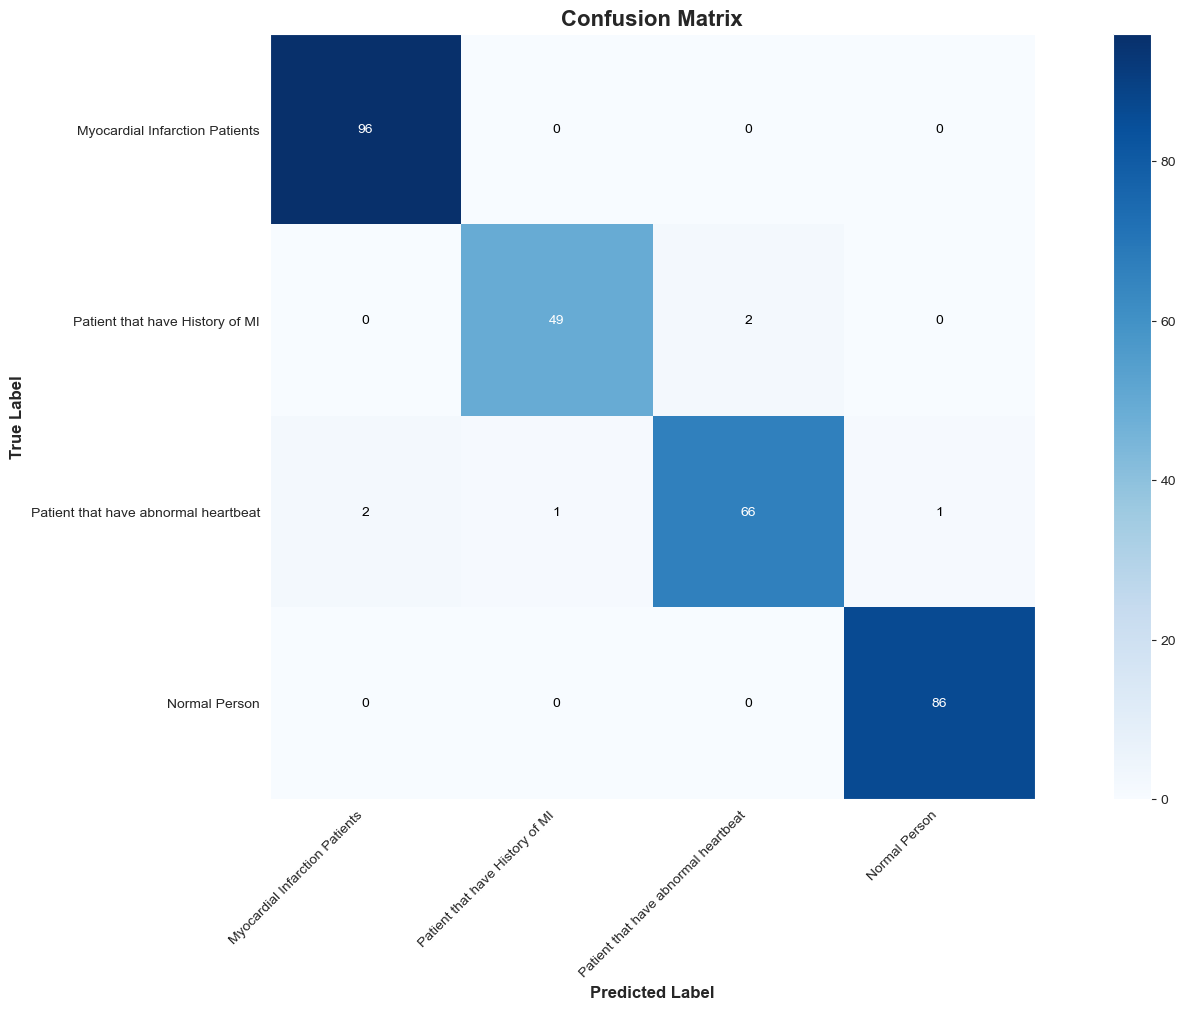

In [18]:
class_names = [
    'Myocardial Infarction Patients',
    'Patient that have History of MI',
    'Patient that have abnormal heartbeat',
    'Normal Person'
]

g_dict = test_gen.class_indices
classes = list(g_dict.keys())

print("Detected classes:", classes)
print("Number of classes:", len(classes))

cm = confusion_matrix(test_gen.classes, y_pred)

plt.figure(figsize=(16, 10))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix', fontsize=16, fontweight='bold')
plt.colorbar()

tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names, rotation=45, ha='right')
plt.yticks(tick_marks, class_names)

plt.grid(False)

thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, format(cm[i, j], 'd'),
             horizontalalignment='center',
             verticalalignment='center',
             color='white' if cm[i, j] > thresh else 'black',
             fontsize=10)

plt.tight_layout()
plt.ylabel('True Label', fontsize=12, fontweight='bold')
plt.xlabel('Predicted Label', fontsize=12, fontweight='bold')

plt.show()

10/10 ━━━━━━━━━━━━━━━━━━━━ 36s 4s/step


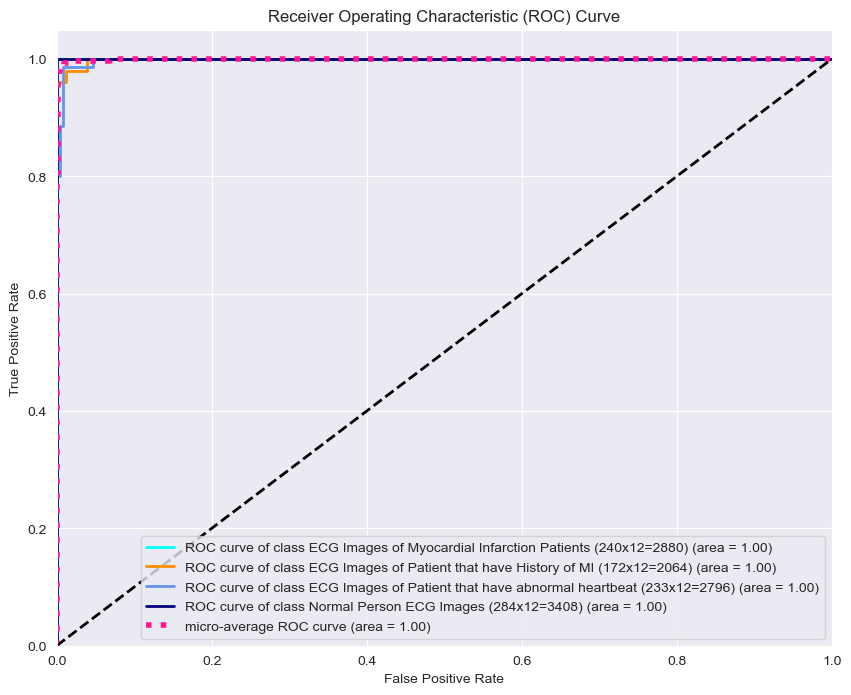

In [19]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.metrics import confusion_matrix, roc_auc_score
import matplotlib.pyplot as plt
import numpy as np
import itertools


n_classes = len(classes)

y_true = label_binarize(test_gen.classes, classes=range(n_classes))
y_pred_probs = model.predict(test_gen) 

fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true[:, i], y_pred_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

fpr["micro"], tpr["micro"], _ = roc_curve(y_true.ravel(), y_pred_probs.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

plt.figure(figsize=(10, 8))
colors = itertools.cycle(['aqua', 'darkorange', 'cornflowerblue', 'navy', 'deeppink', 'seagreen'])

for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(classes[i], roc_auc[i]))

plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
         ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")

plt.savefig('roc_curve1.png',  dpi=1200) 
plt.show()

In [20]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
import tensorflow as tf

class StopAt98Accuracy(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        if logs.get('accuracy') >= 0.98 or logs.get('val_accuracy') >= 0.98:
            acc_type = "TRAINING" if logs.get('accuracy') >= 0.98 else "VALIDATION"
            print(f"\nReached 98% {acc_type} accuracy at epoch {epoch+1}. Stopping training!")
            self.model.stop_training = True

def build_improved_model(base_model, num_classes=4):
    base_model.trainable = True
    
    for layer in base_model.layers[:-10]:
        layer.trainable = False
    
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = BatchNormalization()(x)
    x = Dense(512, activation='relu')(x)
    x = Dropout(0.5)(x)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.3)(x)
    predictions = Dense(num_classes, activation='softmax')(x)
    
    model = Model(inputs=base_model.input, outputs=predictions)
    
    model.compile(optimizer=Adam(learning_rate=0.0001), 
                  loss='categorical_crossentropy', 
                  metrics=['accuracy'])
    return model

callbacks = [
    StopAt98Accuracy(),
    EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-7)
]

In [22]:
base_model = VGG16(weights='imagenet', include_top=False, input_shape=input_shape)
model_vgg16_improved = build_improved_model(base_model, num_classes=4)

history = model_vgg16_improved.fit(
    train_gen, 
    validation_data=valid_gen, 
    epochs=10, 
    callbacks=callbacks
)

accuracy_vgg16_improved = model_vgg16_improved.evaluate(valid_gen)[1]
print(f"Improved VGG16 Accuracy: {accuracy_vgg16_improved:.4f}")

Epoch 1/10
76/76 ━━━━━━━━━━━━━━━━━━━━ 575s 7s/step - accuracy: 0.4791 - loss: 1.1798 - val_accuracy: 0.2517 - val_loss: 1.3785 - learning_rate: 1.0000e-04
Epoch 2/10
76/76 ━━━━━━━━━━━━━━━━━━━━ 370s 5s/step - accuracy: 0.8543 - loss: 0.4491 - val_accuracy: 0.2815 - val_loss: 5.2578 - learning_rate: 1.0000e-04
Epoch 3/10
76/76 ━━━━━━━━━━━━━━━━━━━━ 354s 5s/step - accuracy: 0.9469 - loss: 0.1757 - val_accuracy: 0.4238 - val_loss: 6.1767 - learning_rate: 1.0000e-04
Epoch 4/10
76/76 ━━━━━━━━━━━━━━━━━━━━ 350s 5s/step - accuracy: 0.9649 - loss: 0.1283 - val_accuracy: 0.5000 - val_loss: 4.7485 - learning_rate: 1.0000e-04
Epoch 5/10
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.9830 - loss: 0.0564
Reached 98% TRAINING accuracy at epoch 5. Stopping training!
76/76 ━━━━━━━━━━━━━━━━━━━━ 365s 5s/step - accuracy: 0.9831 - loss: 0.0561 - val_accuracy: 0.9503 - val_loss: 0.1539 - learning_rate: 2.0000e-05
10/10 ━━━━━━━━━━━━━━━━━━━━ 34s 3s/step - accuracy: 0.9573 - loss: 0.1376
Improved VGG16 Accu

In [23]:
model.save("models/model_vgg16_improved.keras")

In [24]:
import os
print(os.getcwd())

D:\Documents\memoire\realisation\ECG_MI_Predict\notebooks


In [25]:
import os

os.makedirs("models", exist_ok=True)

In [26]:
model.save("models/model_vgg16_improved.keras")
print("Modèle sauvegardé avec succès ✅")

Modèle sauvegardé avec succès ✅


In [27]:
print(os.listdir("models"))

['model.h5', 'model_vgg16_improved.keras']
